# Lilbraries & functions

In [2]:
import numpy as np
import pandas as pd
import pyBigWig as bw

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from KalmanFilter import *

# vectorized version
def hsv_to_rgb_v( h, s, v) -> tuple:
    
    out = np.full([h.shape[0],3], np.nan)

    h[h==1.0] = 0.0
    i = (h*6.0).astype(int)
    f = h*6.0 - i
        
    w = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i[s==0] = -1

    out[i==0,:] = np.array([v[i==0],t[i==0],w[i==0]]).T
    out[i==1,:] = np.array([q[i==1],v[i==1],w[i==1]]).T
    out[i==2,:] = np.array([w[i==2],v[i==2],t[i==2]]).T
    out[i==3,:] = np.array([w[i==3],q[i==3],v[i==3]]).T
    out[i==4,:] = np.array([t[i==4],w[i==4],v[i==4]]).T
    out[i==5,:] = np.array([v[i==5],w[i==5],q[i==5]]).T
    out[i==-1,:] = np.array([v[i==-1],v[i==-1],v[i==-1]]).T

    return out

# Toy example

loglik =  -3029.3834624863525


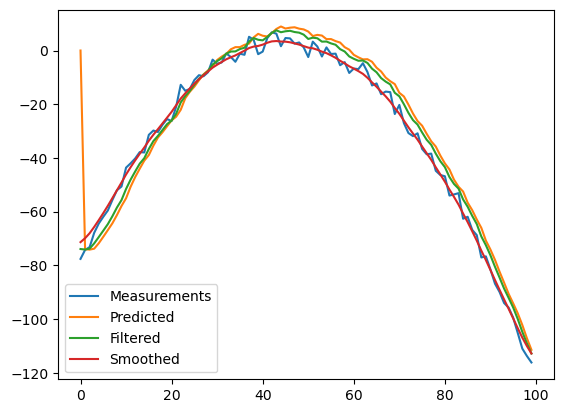

In [112]:
dt = 1.0/60
F = np.array([[[1, dt, 0], [0, 1, dt], [0, 0, 1]]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

kf = KalmanFilter(F = F, H = H, Q = Q, R = R, μ_0 = np.array([0,0,0]), Σ_0 = np.eye(3)*10)

predicted = []
filtered = []
for z in measurements:
    predicted.append(np.dot(H,  kf.predict()[0]))
    filtered.append(np.dot(H,  kf.update(z)[0]))

plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predicted)), np.array(predicted), label = 'Predicted')
plt.plot(range(len(filtered)), np.array(filtered), label = 'Filtered')

#test Forward-Backward
forward_table, ll = kf.fullForward(measurements)
print('loglik = ', ll)

smoothed = kf.Backward(forward_table,F)[0]
s=(H[:,None,:] * np.array(smoothed)[None,:,:]).sum(axis=2).squeeze()
plt.plot(range(len(measurements)), s, label = 'Smoothed')
plt.legend()
plt.show()


In [107]:
(F.shape[0]-1)

0

array([[1, 0, 0]])

# PROseq

## Get dataset

In [3]:
# Parameters
bw_path = '../results/binned_norm_counts'
bin_size = 1000 # bp
Strands = ['forward', 'reverse']
strand_dict = {'forward':'+', 'reverse':'-', '+':'forward', '-':'reverse'}
P = 24
T = np.arange(0,48,4)
Nt = len(T)
#CHR = [f'chr{i}' for i in range(1,19)] + ['chrX','chrY','chrM']
chr = 'chr17'

# Load bigWigs
bw_files = {}
for t in T:
    sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001'
    bw_files[t] = {}
    for strand in Strands:
        fin = f"{bw_path}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw"
        bw_files[t][strand] = bw.open(fin)

# get data
df = {}
for strand in Strands:
    df[strand] = pd.DataFrame(columns=['start','end'])
    for t in T:
        df_t = pd.DataFrame(bw_files[t][strand].intervals(chr))
        df_t.columns = ['start','end',f"{t}"]
        df[strand] = pd.merge(df[strand],df_t,on=['start','end'],how='outer')
    df[strand].sort_values('start',inplace=True)

# merge forward and reverse (sum)
df = pd.merge(df['forward'],df['reverse'],on=['start','end'],how='outer')
for t in T:
    idx_na = df[[f"{t}_x",f"{t}_y"]].isna().all(1)
    df[f"{t}"] = df[[f"{t}_x",f"{t}_y"]].sum(1)
    df.loc[idx_na,f"{t}"] = np.nan
    df.drop([f"{t}_x",f"{t}_y"],axis=1,inplace=True)

# remove position with 75% or more missing values (at least 5 out of 12 time points)
df = df.loc[df.isna().sum(1)/len(T) < 0.75,:]
df.sort_values('start',inplace=True)
df.reset_index(inplace=True,drop=True)

# replace start and end with position in the middle of the bin, and set as index
df['start'] = ( (df.start.values + df.end.values)/2 ).astype(int) # bp
df.drop('end',axis=1,inplace=True)
df.columns = ['pos'] + [f"{t}" for t in T]
df.set_index('pos',inplace=True)

# add missing positions
if False:
    pos = df.index.astype(int)
    new_pos = np.sort( list( set(np.arange(pos[0],pos[-1]+bin_size,bin_size,dtype='int')) - set(pos) ) )
    a = np.zeros((len(new_pos),df.shape[1]))
    a = pd.DataFrame(a,index=new_pos,columns=df.columns)
    df = pd.concat([df,a],axis=0)
    df.sort_index(inplace=True)

# replace missing values with 0
df.fillna(0,inplace=True)

# Add psudocount and take the log
df = df.apply(lambda x: np.log(x+1/bin_size),axis=1)

# get predicted values
df_pred = pd.read_csv(f'../results/phase_amp/bin_phase_amp_{bin_size}bp.csv',index_col=0)

In [14]:
df.to_csv(f'../results/{chr}_{bin_size}bp.csv',sep='\t',index=True)

In [128]:
Λ_min = 4.5
Λ_max = 6
K_min = 2*np.pi/Λ_max
K_max = 2*np.pi/Λ_min

In [132]:
K_min

1.0471975511965976

## Kalman filtering and smoothing

31622.776601683792
loglik =  -19870.223889179262
37926.90190732246
loglik =  -19821.83921606825
45487.77947003778
loglik =  -19764.443742500243
54555.947811685146
loglik =  -19708.235877667776
65431.89129712969
loglik =  -19649.95492362166
78475.99703514607
loglik =  -19596.17248500887
94120.49672680671
loglik =  -19553.54982310137
112883.78916846884
loglik =  -19520.662658015775
135387.61800225446
loglik =  -19495.12589093772
162377.67391887208
loglik =  -19475.77824590071
194748.30399087572
loglik =  -19461.626436763076
233572.14690901214
loglik =  -19451.485049217197
280135.676119887
loglik =  -19444.229362214774
335981.8286283781
loglik =  -19438.984542973452
402961.1320200396
loglik =  -19435.138460786075
483293.0238571752
loglik =  -19432.279022095383
579639.3953384974
loglik =  -19430.128336109898
695192.7961775606
loglik =  -19428.495214664574
833782.2234717883
loglik =  -19427.244977046994
1000000.0
loglik =  -19426.280832883363
inf
loglik =  -19422.57086417949
-1000000.0
logl

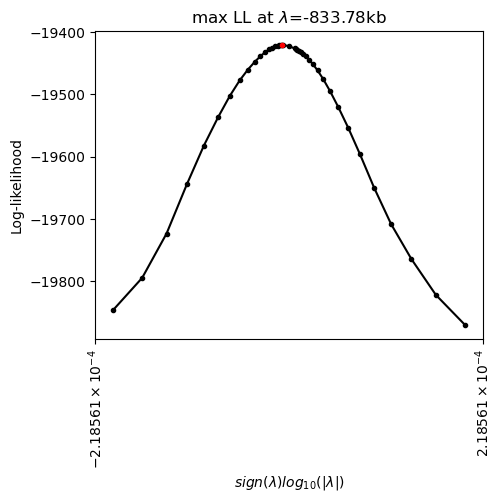

In [203]:
#My_win = [35_000_000, 35_150_000]
#My_win = [34_891_000, 35_434_000]
My_win = [26_000_000, 27_500_000]
#My_win = [24_000_000, 30_000_000]

# Kalman filter
Λ = np.logspace(4.5, 6, 20) # wavelengths in bp
# add the negative values
Λ = np.append(np.append(Λ,np.inf),-np.flip(Λ))

# get only the first a small region of the chromosome
idx_pos = (df.index >= My_win[0]) & (df.index <= My_win[1])
measurements = df.loc[idx_pos,:].values.T # time x position
measurements -= measurements.mean(0) # centering
measurements /= measurements.std(0) # scaling
positions = df.loc[idx_pos,:].index # positions
dx = np.diff(df.loc[idx_pos,:].index) # bp between positions
dx = np.append(bin_size,dx) # add bin size for the first position
[m,N_mes] = measurements.shape # number of measurements

ω = 2*np.pi/P # angular frequency
m = len(T) # number of time points
n = 2 # number complex state

LL = np.zeros(len(Λ))
Res = np.zeros((len(Λ),3))

μ_tT_best = np.zeros((n,N_mes))
Σ_tT_best = np.zeros((n,n,N_mes))
ll_best = -np.inf

for l,λ in enumerate(Λ):
    print(λ)

    k = 2*np.pi/λ # wave number

    # forward model: rotation matrix
    idx_pos = (df.index > 34_891_000) & (df.index < 35_434_000)

    θ = dx/λ*2*np.pi
    F = np.zeros((N_mes,n,n))
    F[:,0,0] = np.cos(θ)
    F[:,0,1] = -np.sin(θ)
    F[:,1,0] = np.sin(θ)
    F[:,1,1] = np.cos(θ)

    #F = np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])
    # process noise
    Q = np.eye(n)*0.05
    # observation model: inverse fourier transform
    H = np.zeros((m,2))
    H[:,0] = np.cos(ω*T)
    H[:,1] = -np.sin(ω*T)
    H /= 6
    # mesurment noise
    R = np.eye(m)*0.5

    # initial state
    μ_0 = np.zeros(n)
    Σ_0 = np.eye(n)*1

    kf = KalmanFilter(F=F, H=H, Q=Q, R=R, μ_0=μ_0, Σ_0=Σ_0)

    μ_pred = np.zeros((n,N_mes))
    Σ_pred = np.zeros((n,n,N_mes))
    predicted = np.zeros((m,N_mes))
    μ_t = np.zeros((n,N_mes))
    Σ_t = np.zeros((n,n,N_mes))
    filtered = np.zeros((m,N_mes))
    for i,z in enumerate(measurements.T):
        μ_pred[:,i], Σ_pred[:,:,i] = kf.predict(i)
        μ_t[:,i], Σ_t[:,:,i] = kf.update(z)

    #test Forward-Backward
    forward_table, ll = kf.fullForward(measurements)
    print('loglik = ', ll)
    LL[l] = ll

    μ_tT, Σ_tT = kf.Backward(forward_table,F)
    μ_tT = np.array(μ_tT).T

    # save the best
    if ll > ll_best:
        ll_best = ll
        μ_tT_best = μ_tT
        Σ_tT_best = Σ_tT

    if False:
        predicted = H @ μ_pred
        filtered = H @ μ_t
        smoothed = H @ np.array(μ_tT).T

        # get residuals
        residuals = {}
        residuals['predicted'] = (measurements - predicted)**2
        residuals['filtered'] = (measurements - filtered)**2
        residuals['smoothed'] = (measurements - smoothed)**2

        for k,key in enumerate(residuals.keys()):
            Res[l,k] = residuals[key].mean()

    
# plot ll and residuals as a function of wavelength
xvals = [str(np.round(v,2)) for v in np.sign(Λ)*np.log10(np.abs(Λ))]

# find the maximum
x_max = LL.argmax()
λ_max = Λ[LL.argmax()]
y_max = LL.max()

r_max = Res[LL.argmax(),:]


plt.figure(figsize=(5,4))
plt.subplot(111)
plt.plot(2*np.pi/Λ,LL,'k.-')
plt.plot(2*np.pi/λ_max,y_max,'r.')
plt.xticks(1/Λ[::5],1/Λ[::5],rotation=90)
plt.xlabel(r'$sign(\lambda) log_{10}(|\lambda|)$')
plt.ylabel('Log-likelihood')
plt.title(rf'max LL at $\lambda$={λ_max/1e3:.2f}kb')
plt.xscale('symlog')

# save figure
plt.savefig(f'../results/chr17_{My_win[0]//1e6}_{My_win[1]//1e6}_Mb.pdf')

plt.show()





## Fourier transform

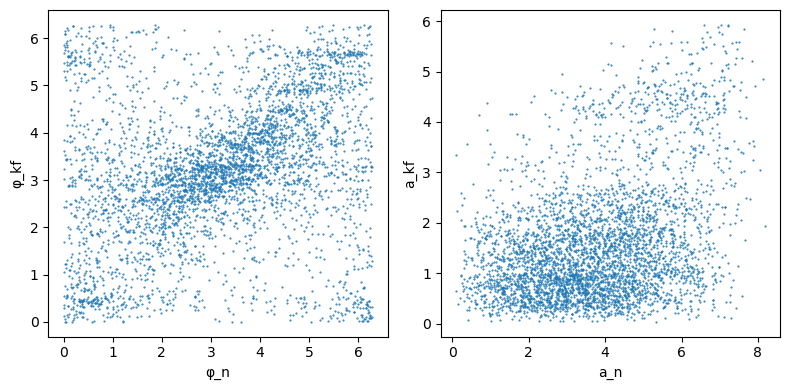

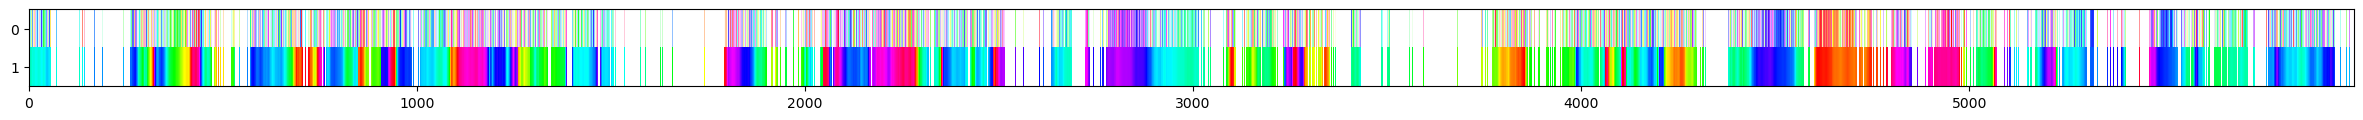

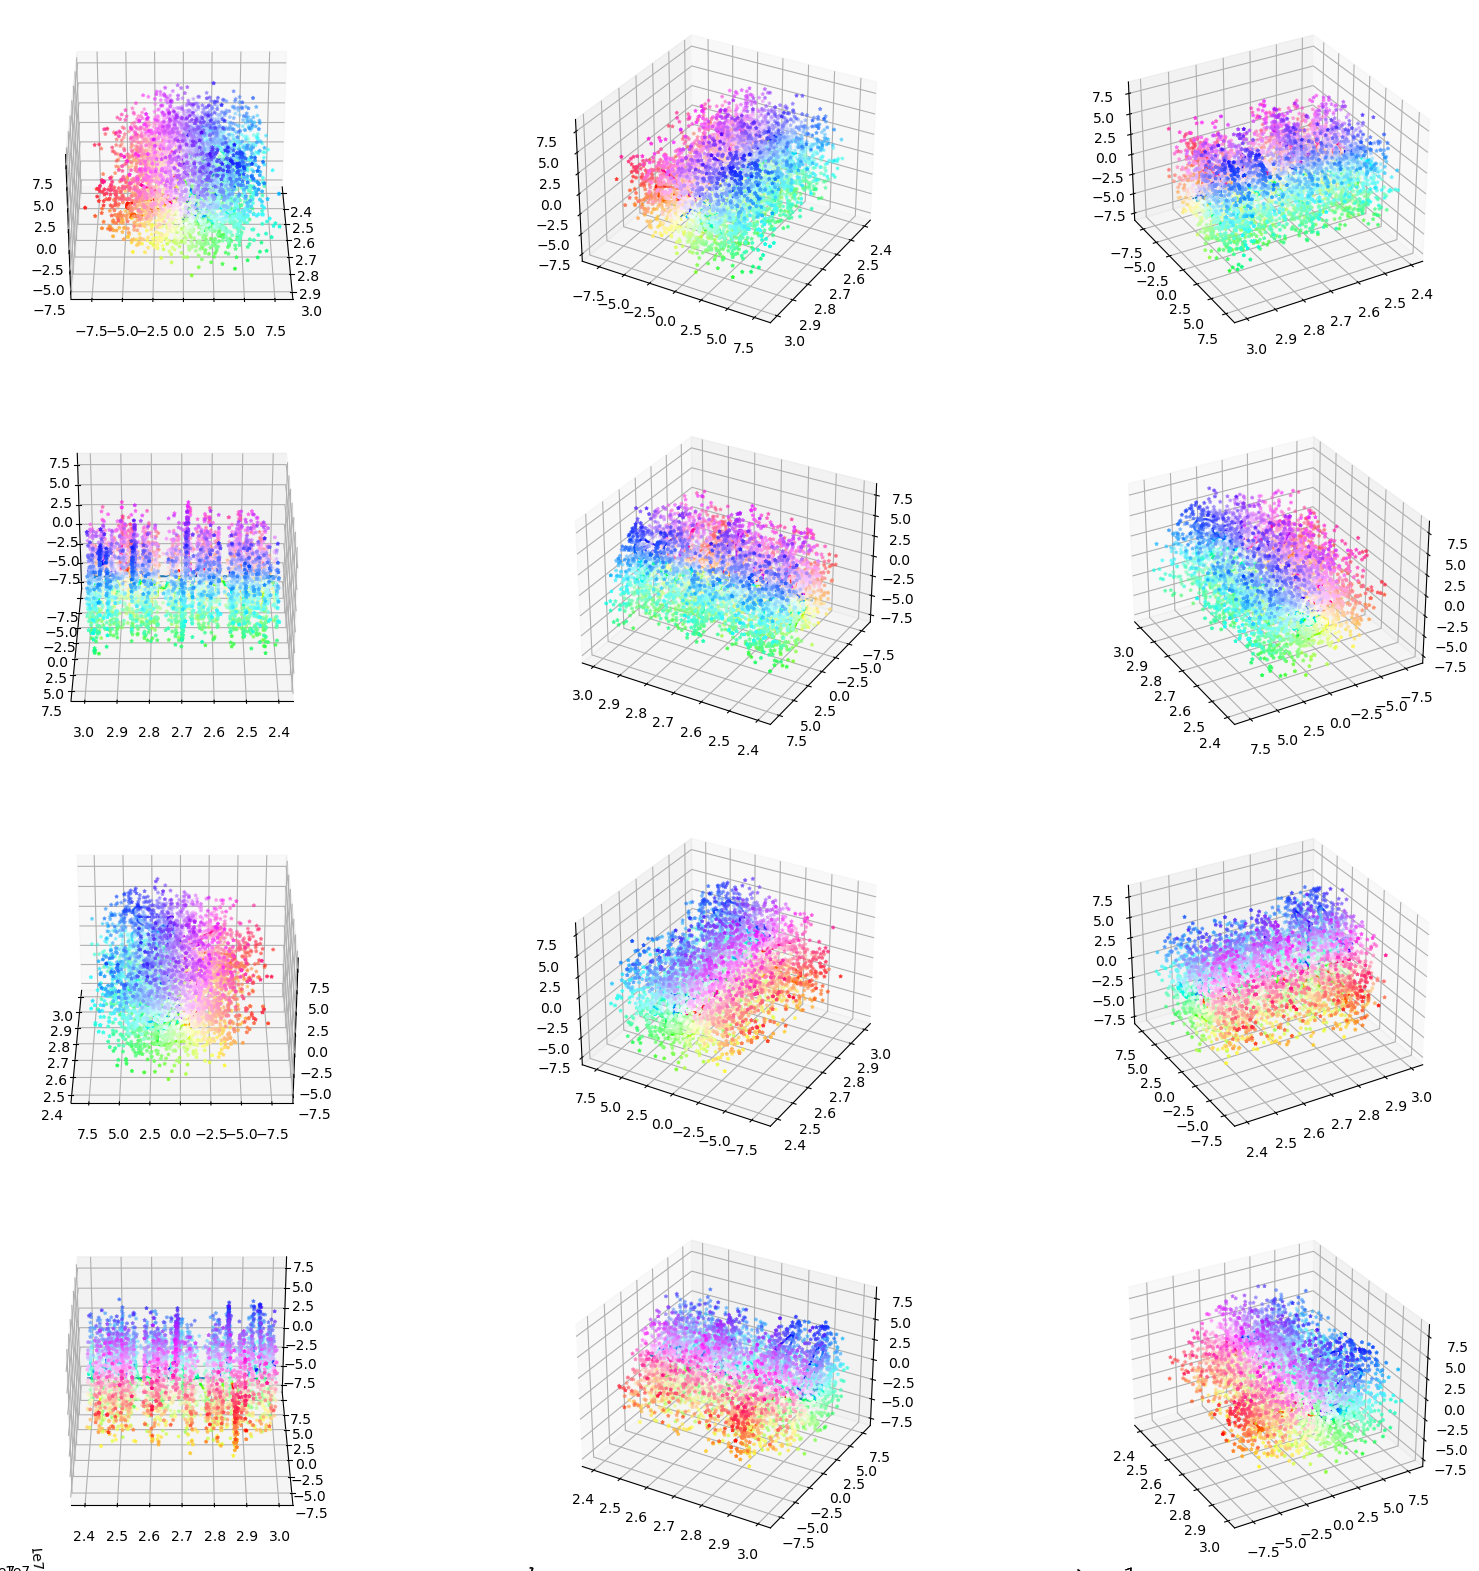

In [202]:
# Compare best with bin by bin fourrier transform

# fourier transform
f_n = np.sum(measurements * np.exp(-1j*ω*T[:,None]),0)
a_n = np.abs(f_n)
# normalize
φ_n = np.angle(f_n) + np.pi
# in between 0 and 2pi

# plot phase per bin
h = φ_n/(2*np.pi)
s = a_n/a_n.max()
v = np.ones(len(positions))
color_f = hsv_to_rgb_v(h,s,v)


μ_tT_best_C = μ_tT_best[0,:] + 1j*μ_tT_best[1,:]
a_kf = np.abs(μ_tT_best_C)
φ_kf = np.angle(μ_tT_best_C) + np.pi

h = φ_kf/(2*np.pi)
s = np.ones(len(positions))#a_kf/a_kf.max()
v = np.ones(len(positions))
color_kf = hsv_to_rgb_v(h,s,v)

fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(φ_n,φ_kf,s=1,marker='.')
plt.xlabel('φ_n')
plt.ylabel('φ_kf')

plt.subplot(122)
plt.scatter(a_n,a_kf,s=1,marker='.')
plt.xlabel('a_n')
plt.ylabel('a_kf')

fig.tight_layout()

# plot phase per bin
x = np.arange(positions[0],positions[-1]+1,bin_size)
idx = [np.where(x==pos)[0][0] for pos in positions]
X = np.ones((2,len(x),3))
X[0,idx] = color_f
X[1,idx] = color_kf
fig = plt.figure(figsize=(30,1))
plt.imshow(X,aspect='auto',interpolation='none')

if True:
    fig = plt.figure(figsize=(20,20))
    for f,azim in enumerate( range(0,360,30) ):
        ax = fig.add_subplot(4,3,f+1, projection='3d')
        ax.scatter(xs=positions, ys=f_n.real, zs=f_n.imag,color=color_f,s=5,marker='*')
        ax.scatter(xs=positions, ys=μ_tT_best_C.real, zs=μ_tT_best_C.imag,color=color_kf,s=1,marker='o')
        #ax.plot3D(positions,f_n.real,f_n.imag,color='k',linewidth=0.5)
        #for i in range(len(positions)):
        #    ax.plot3D([positions[i],positions[i]],[f_n.real[i],μ_tT_best_C.real[i]],[f_n.imag[i],μ_tT_best_C.imag[i]],color='k',linewidth=0.5)
        #ax.plot3D(positions,μ_tT_best_C.real,μ_tT_best_C.imag,color='k',linewidth=0.5)
        ax.plot3D(x,np.zeros(len(x)),np.zeros(len(x)))
        ax.view_init(elev=30, azim=azim, roll=0)


    #plt.draw()
    #plt.pause(.5)
#plt.show()

if False:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Grab some example data and plot a basic wireframe.
    ax.plot_wireframe(x, y ,z , rstride=10, cstride=10)

    # Set the axis labels
    ax.set_xlabel('position')
    ax.set_ylabel('Re(f_n)')
    ax.set_zlabel('Im(f_n)')

    # Rotate the axes and update
    for angle in range(0, 360 + 1,20):
        # Normalize the angle to the range [-180, 180] for display
        angle_norm = (angle + 180) % 360 - 180

        # Cycle through a full rotation of elevation, then azimuth, roll, and all
        elev = azim = roll = 0
        if angle <= 360:
            elev = angle_norm
        elif angle <= 360*2:
            azim = angle_norm
        elif angle <= 360*3:
            roll = angle_norm
        else:
            elev = azim = roll = angle_norm

        # Update the axis view and title
        ax.view_init(elev, azim, roll)
        plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

        plt.draw()
        plt.pause(.001)


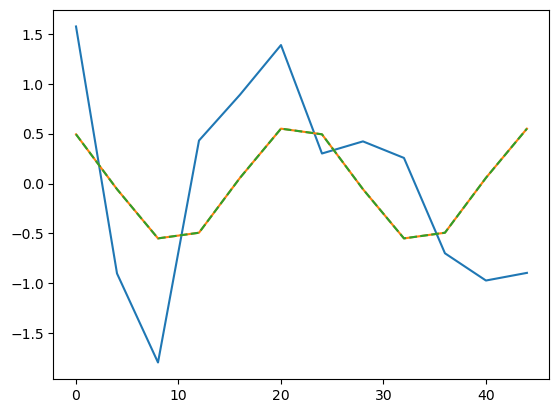

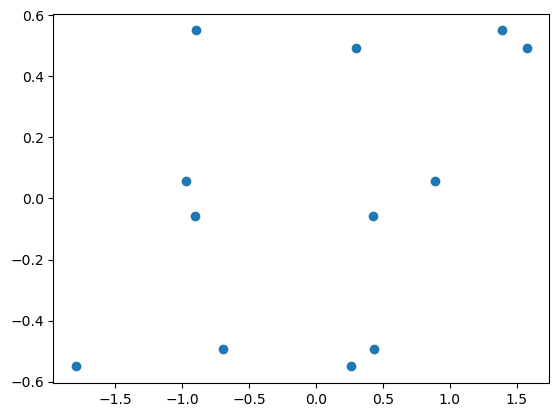

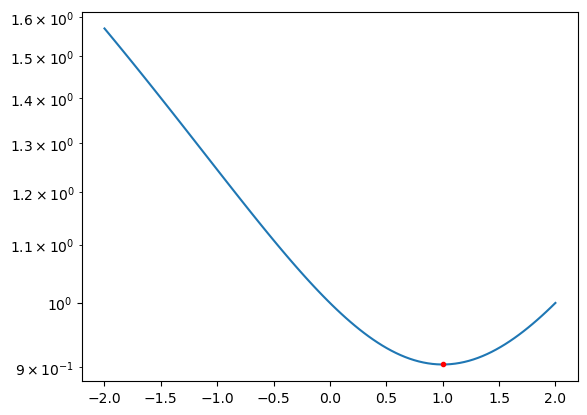

In [192]:
ω = 2*np.pi/P # angular frequency

H = np.zeros((m,2))
H[:,0] = np.cos(ω*T)
H[:,1] = -np.sin(ω*T)


x_t = measurements[:,0]

X_n = np.sum( x_t * np.exp(-1j*ω*T) )
x_t_recon = np.real( X_n * np.exp(1j*ω*T) )/6
x_t_recon_H = H @ np.array([X_n.real,X_n.imag])/6

plt.figure()
plt.plot(T,x_t,label='original')
plt.plot(T,x_t_recon,label='reconstructed')
plt.plot(T,x_t_recon_H,label='reconstructed H',linestyle='--')

plt.figure()
plt.scatter(x_t,x_t_recon)

c = np.linspace(-2,2,100)
res = np.sqrt(np.mean((x_t - c[:,None]*x_t_recon)**2,1))

def f(c):
    return np.sqrt(np.mean((x_t - c*x_t_recon)**2))

# minimize
from scipy.optimize import minimize
res_min = minimize(f,0,method='Nelder-Mead',tol=1e-10).x


plt.figure()
plt.plot(c,res)
plt.plot(res_min,f(res_min),'r.')
plt.yscale('log')


In [193]:
res_min

array([0.99999999])

12